In [1]:
import json
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os

In [2]:
#Iterate the HSUBANOTT/human_scanpaths folder, there should be multiple json files.
#Each json file contains the scanpaths of a single participant (the id of the participant is the name of the file), the keys of the json files are the names of the images.
# the values of the json file for each key is a structure, in these case we are interested in these keys:
# target_found, target_present, target_stim, memory_set, len(X),seen_order,fix_proportion_mem
# With that we can build a dataframe with these columns:
# participant, image, target_found, target_present, target_stim, scanpath_length,seen_order_index,fix_proportion_mem_index
# To get the data for seen_order_index we need to iterate the memory_set and check the index of target_stim in the memory_set
# Then, we need to look up that index in the seen_order list and get the value of that index in the seen_order list
# That will be the value of seen_order_index for that row in the dataframe
# For fix_proportion_mem_index we use the same index that we used for seen_order_index, 
# for example if the value we are looking up is 3 and seen_order is [2,3,1,0]
# and fix_proportion_mem is [0.1,0.2,0.3,0.4] then the value of fix_proportion_mem for that row will be 0.2
# and the value for seen_order_index will be 1 (assuming we start counting from 0)

#Code for building the dataframe:
list = []
list_with_empty_seen_orders = []
#Iterate the files in the folder
for file in os.listdir('HSUBANOTT/human_scanpaths'):
    with open('HSUBANOTT/human_scanpaths/'+file) as f:
        data = json.load(f)
        for key in data:            
            scanpath_data = data[key]
            # if scanpath_data["seen_order"] is empty we skip this image
            target_object_in_mem_set_index = scanpath_data['memory_set'].index(scanpath_data['target_stim'])
            seen_order_index = scanpath_data['seen_order'].index(target_object_in_mem_set_index) if target_object_in_mem_set_index in scanpath_data['seen_order'] else None
            fix_proportion_mem_index = scanpath_data['fix_proportion_mem'][seen_order_index] if seen_order_index is not None else None
            order_fix_proportion_mem = sorted(scanpath_data['fix_proportion_mem'])
            target_order_fix_proportion_mem_index = order_fix_proportion_mem.index(fix_proportion_mem_index) if fix_proportion_mem_index is not None else None
            scanpath_length = len(scanpath_data['X'])
            mss = len(scanpath_data['memory_set'])
            if scanpath_data["seen_order"]:
                list.append({'participant':file[:-15],'image':key,'target_found':scanpath_data['target_found'],'target_present':scanpath_data['target_present'],'target_stim':scanpath_data['target_stim'],'scanpath_length':scanpath_length,'seen_order_index':seen_order_index,'target_order_fix_proportion_mem_index':target_order_fix_proportion_mem_index,'target_object_in_mem_set_index':target_object_in_mem_set_index,'memory_set_size':mss})
            list_with_empty_seen_orders.append({'participant':file[:-15],'image':key,'target_found':scanpath_data['target_found'],'target_present':scanpath_data['target_present'],'target_stim':scanpath_data['target_stim'],'scanpath_length':scanpath_length,'seen_order_index':seen_order_index,'target_order_fix_proportion_mem_index':target_order_fix_proportion_mem_index,'target_object_in_mem_set_index':target_object_in_mem_set_index,'memory_set_size':mss})
df = pd.DataFrame(list)
df_full = pd.DataFrame(list_with_empty_seen_orders)
print('Empty seen orders:',len(df_full)-len(df))

df

# 2692 empty seen orders and a df with 1750 rows, taking into account that for each subject the first
# trial should have an empty seen order because of the problem with the EEG for those trials (43 rows)
# we can say that there is a problem with how seen_order is being calculated AKA the criteria for
# determining when a subject is looking at an object in the memorization stage is wrong.

Empty seen orders: 355


,participant,image,target_found,target_present,target_stim,scanpath_length,seen_order_index,target_order_fix_proportion_mem_index,target_object_in_mem_set_index,memory_set_size
0,et_117969,cmp_building_056_bird_012.jpg,False,True,bird1145.png,16,0.0,1.0,0,2
1,et_117969,cmp_shelves_101_teddybear_014.jpg,True,True,teddy bear394.png,10,0.0,1.0,0,2
2,et_117969,cmp_yard_003_animal_002.jpg,True,True,sheep864.png,4,1.0,0.0,1,2
3,et_117969,cmp_snow_004_dog_001.jpg,False,True,dog1799.png,19,0.0,0.0,1,2
4,et_117969,cmp_shelves_109_teddybear_022.jpg,True,True,teddy bear838.png,12,0.0,0.0,0,1
...,...,...,...,...,...,...,...,...,...,...
4082,S119,cmp_shelves_008_fruitvegetal_001.jpg,True,True,carrot46.png,13,0.0,0.0,0,2
4083,S119,cmp_office_001_pottedplant_001.jpg,True,True,potted plant870.png,17,0.0,0.0,0,1
4084,S119,cmp_yard_001_birds_001.jpg,False,True,bird489.png,20,3.0,0.0,2,4
4085,S119,cmp_building_032_cat_011.jpg,False,True,cat219.png,5,NaN,NaN,1,2


In [3]:
#Count rows where seen_order_index is None
count = df['seen_order_index'].isnull().sum()
print('There are',count,'rows where seen_order_index is None')

#First, we need to add a different value for seen_order_index when it is NaN, like -1
df['seen_order_index'] = df['seen_order_index'].fillna(-1)

There are 186 rows where seen_order_index is None


In [4]:
# Group the df by seen_order_index and count the number of times each image is present in each group
grouped = df.groupby('seen_order_index')['image'].value_counts().unstack().fillna(0)
grouped

image,cmp_africansavanna_003_wildanimals_003.jpg,cmp_beach_002_person_002.jpg,cmp_beach_003_bird_001.jpg,cmp_building_003_person_001.jpg,cmp_building_006_person_003.jpg,cmp_building_007_person_004.jpg,cmp_building_010_cat_002.jpg,cmp_building_014_person_007.jpg,cmp_building_015_person_008.jpg,cmp_building_018_cat_005.jpg,...,cmp_shelves_114_teddybear_024.jpg,cmp_sky_001_kite_001.jpg,cmp_sky_003_kite_003.jpg,cmp_snow_001_person_001.jpg,cmp_snow_002_animal_002.jpg,cmp_snow_004_dog_001.jpg,cmp_yard_001_birds_001.jpg,cmp_yard_003_animal_002.jpg,cmp_yard_005_animal_003.jpg,cmp_yard_007_motorcycle_001.jpg
seen_order_index,,,,,,,,,,,,,,,,,,,,,
-1.0,0.0,5.0,3.0,2.0,3.0,0.0,1.0,2.0,0.0,0.0,...,2.0,0.0,3.0,0.0,0.0,2.0,5.0,4.0,0.0,2.0
0.0,36.0,27.0,8.0,19.0,5.0,37.0,28.0,15.0,27.0,31.0,...,32.0,41.0,21.0,31.0,8.0,35.0,10.0,26.0,37.0,12.0
1.0,0.0,11.0,16.0,21.0,6.0,0.0,14.0,7.0,0.0,13.0,...,9.0,0.0,20.0,0.0,8.0,7.0,10.0,14.0,0.0,17.0
2.0,0.0,0.0,11.0,0.0,12.0,0.0,0.0,8.0,0.0,0.0,...,0.0,0.0,0.0,0.0,11.0,0.0,6.0,0.0,0.0,6.0
3.0,0.0,0.0,5.0,0.0,18.0,0.0,0.0,12.0,0.0,0.0,...,0.0,0.0,0.0,0.0,17.0,0.0,9.0,0.0,0.0,7.0


In [5]:
# Group the df by target_object_in_mem_set_index and count the number of times each image is present in each group
grouped = df_full.groupby('target_object_in_mem_set_index')['image'].value_counts().unstack().fillna(0)
grouped

image,cmp_africansavanna_003_wildanimals_003.jpg,cmp_beach_002_person_002.jpg,cmp_beach_003_bird_001.jpg,cmp_building_003_person_001.jpg,cmp_building_006_person_003.jpg,cmp_building_007_person_004.jpg,cmp_building_010_cat_002.jpg,cmp_building_014_person_007.jpg,cmp_building_015_person_008.jpg,cmp_building_018_cat_005.jpg,...,cmp_shelves_114_teddybear_024.jpg,cmp_sky_001_kite_001.jpg,cmp_sky_003_kite_003.jpg,cmp_snow_001_person_001.jpg,cmp_snow_002_animal_002.jpg,cmp_snow_004_dog_001.jpg,cmp_yard_001_birds_001.jpg,cmp_yard_003_animal_002.jpg,cmp_yard_005_animal_003.jpg,cmp_yard_007_motorcycle_001.jpg
target_object_in_mem_set_index,,,,,,,,,,,,,,,,,,,,,
0,43.0,24.0,14.0,19.0,8.0,44.0,23.0,12.0,44.0,27.0,...,21.0,44.0,21.0,43.0,5.0,21.0,15.0,21.0,44.0,10.0
1,0.0,19.0,10.0,23.0,13.0,0.0,21.0,8.0,0.0,17.0,...,23.0,0.0,23.0,0.0,9.0,23.0,9.0,23.0,0.0,16.0
2,0.0,0.0,13.0,0.0,10.0,0.0,0.0,8.0,0.0,0.0,...,0.0,0.0,0.0,0.0,10.0,0.0,8.0,0.0,0.0,10.0
3,0.0,0.0,6.0,0.0,13.0,0.0,0.0,16.0,0.0,0.0,...,0.0,0.0,0.0,0.0,20.0,0.0,9.0,0.0,0.0,8.0


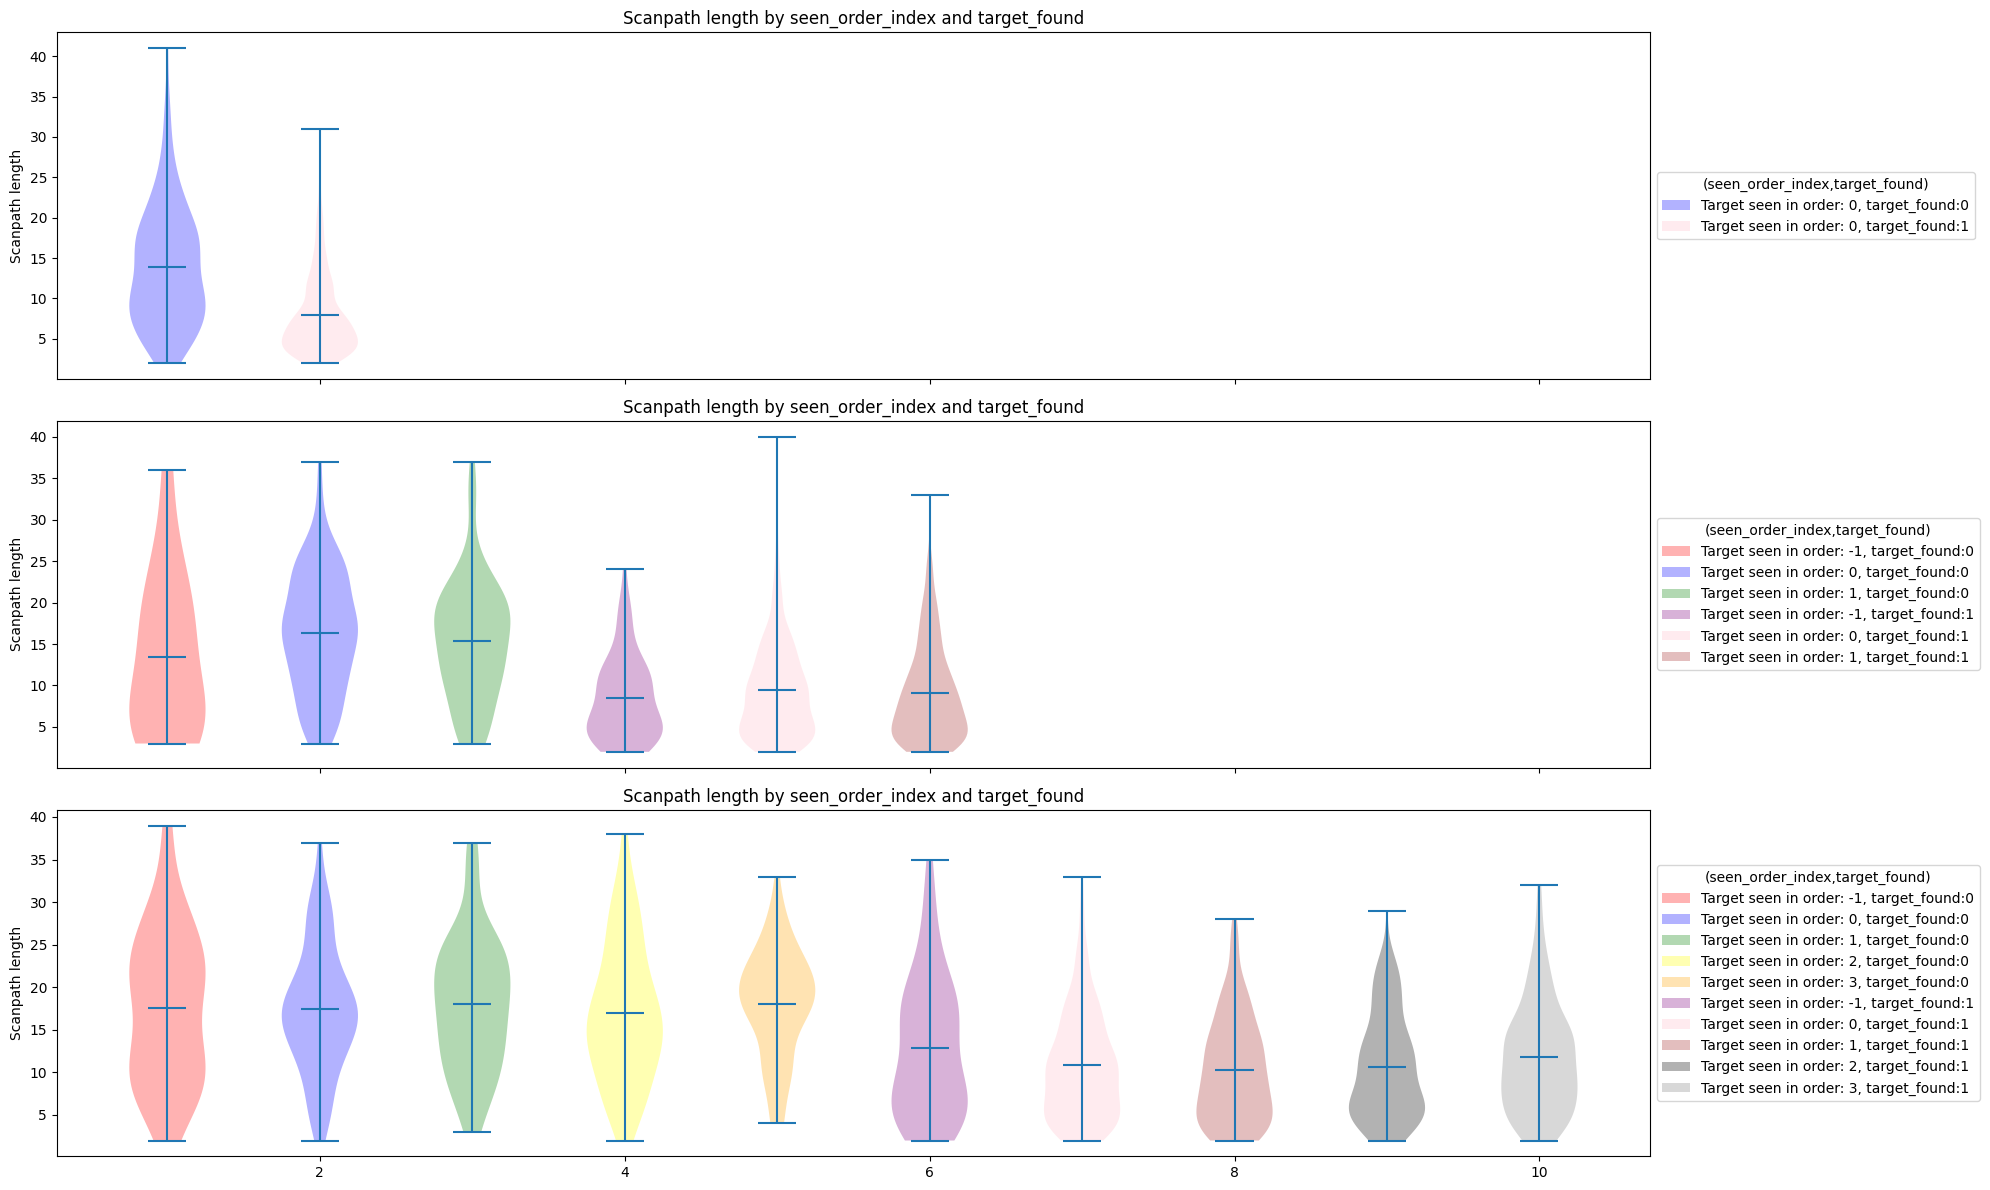

In [6]:
#Create a list of colors for each combination of seen_order_index and target_found, there are 10 combinations

colors = ["red","blue","green","yellow","orange","purple","pink","brown","black","gray"]


# I want to do a violin plot of the scanpath length for each (seen_order_index,target_found) combination
# as for the cases where seen_order_index is None, they should be considered as well in a separate violin plot


#Then we can do the violin plot
fig, ax = plt.subplots(3, 1, figsize=(20,12), sharex=True)

for k,mss in enumerate([1,2,4]):
    # Filter df 
    filtered_mss_df = df[df['memory_set_size'] == mss]
    # Group scanpath_length by seen_order_index and target_found, and place the result in a list
    data = [filtered_mss_df.loc[(df['seen_order_index'] == i) & (df['target_found'] == j), 'scanpath_length'] for j in [0,1] for i in range(-1,4) ]
    legends = [f'Target seen in order: {i}, target_found:{j}' for j in [0,1] for i in range(-1,4)]

    indexes_of_empty_lists = [i for i in range(len(data)) if data[i].empty]
    data = [data[i] for i in range(len(data)) if i not in indexes_of_empty_lists]
    colors_filtered = [colors[i] for i in range(len(colors)) if i not in indexes_of_empty_lists]
    legends = [legends[i] for i in range(len(legends)) if i not in indexes_of_empty_lists]
    # Create the violin plot
    violinplots = ax[k].violinplot(data, showmeans=True)

    for patch, color_ in zip(violinplots['bodies'], colors_filtered):
        patch.set_facecolor(color_)

    # Set title and labels
    ax[k].set_title('Scanpath length by seen_order_index and target_found')
    ax[k].set_ylabel('Scanpath length')

    # Set legend
    ax[k].legend(violinplots['bodies'], legends, title='(seen_order_index,target_found)', loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()
plt.close()

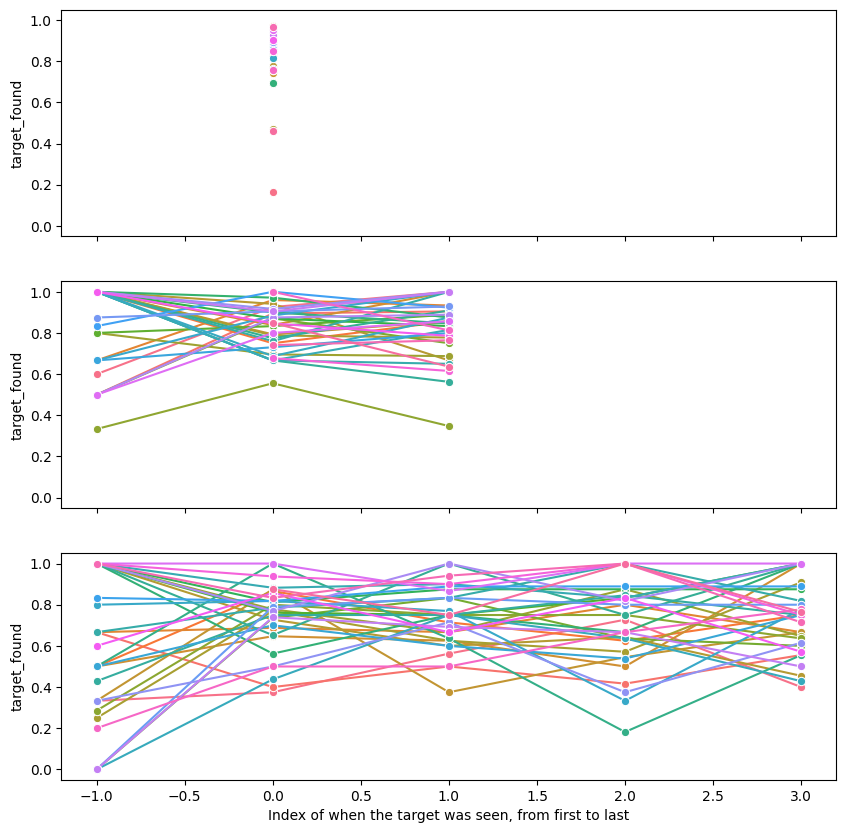

In [7]:
# Plotear curva de accuracy medido sobre imágenes, tomando en cuenta el orden en el que estaba el target en la memoria, debería tener forma de U
# Grab the df and keep (mss,seen_order_index,target_found) and group it by mss and seen_order_index, and then compute the mean, this would give me the accuracy for each combination of mss and seen_order_index
# Then I can plot the accuracy for each combination of mss and seen_order_index
import seaborn as sns
fig,ax = plt.subplots(3,1,figsize=(10,10),sharex=True,sharey=True)
ax[-1].set_xlabel('Index of when the target was seen, from first to last')
for k,mss in enumerate([1,2,4]):
    filtered_mss_df = df[df['memory_set_size'] == mss][['seen_order_index','target_found','image']]
    grouped = filtered_mss_df.groupby(['seen_order_index','image']).mean().reset_index()
    sns.lineplot(data=grouped,x='seen_order_index',y='target_found',ax=ax[k],hue='image',legend=False,marker="o")



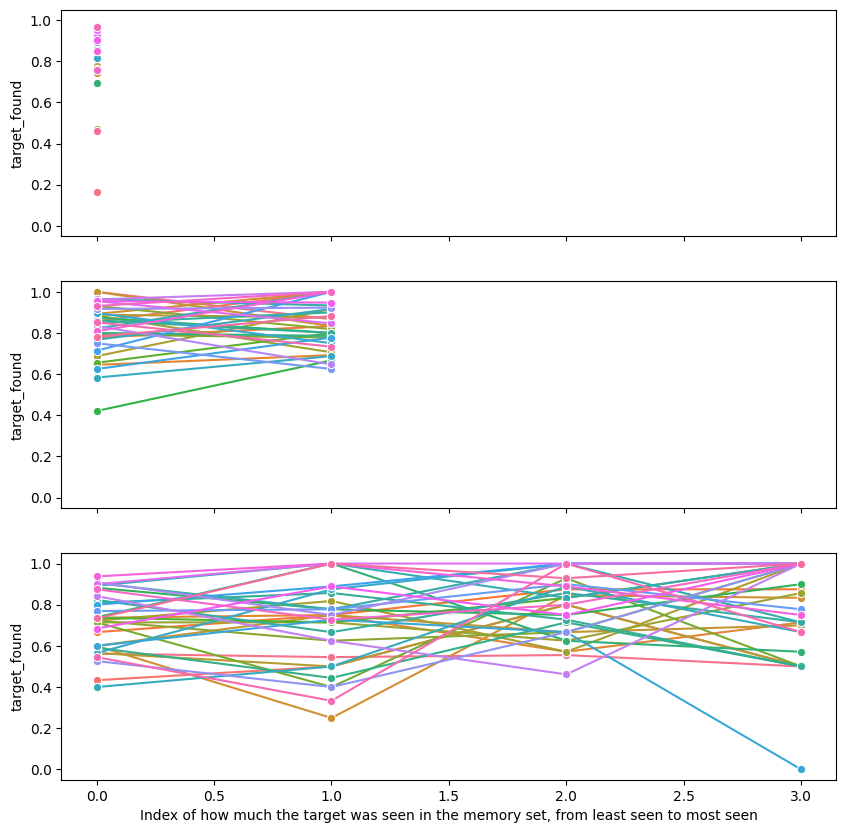

In [8]:
# En el caso de proporción de fijaciones hechas sobre cada objeto, importa más que nada el orden (si el target fue el objeto más visto, el segundo más visto, etc.)
# Puedo plotear la misma curva de accuracy con eso, pero en vez de ser una U debería ser algo decreciente supuestamente


fig,ax = plt.subplots(3,1,figsize=(10,10),sharex=True,sharey=True)
ax[-1].set_xlabel('Index of how much the target was seen in the memory set, from least seen to most seen')
for k,mss in enumerate([1,2,4]):
    filtered_mss_df = df[df['memory_set_size'] == mss][['target_order_fix_proportion_mem_index','target_found','image']]
    grouped = filtered_mss_df.groupby(['target_order_fix_proportion_mem_index','image']).mean().reset_index()
    sns.lineplot(data=grouped,x='target_order_fix_proportion_mem_index',y='target_found',ax=ax[k],hue='image',legend=False,marker="o")
